# Лабораторная работа №1

## Вариант 44

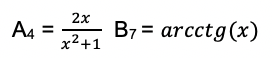

## Импорты

In [1]:
%%capture
# Установка необходимых модулей
!pip install --upgrade pip setuptools wheel
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install tabulate

In [2]:
%%capture
import numpy as np;
import pandas as pd;

import matplotlib.pyplot as plt;
import seaborn as sns;
sns.set_style("whitegrid");

import typing;
from dataclasses import dataclass;
import abc;

## Вспомогательные функции

In [3]:
@dataclass
class LineSegment(object):
    left_border: float
    right_border: float

    @property
    def middle(self):
        return np.mean([self.left_border, self.right_border])

    def __str__(self):
        left_border_format = ('%f' % self.left_border).rstrip('0').rstrip('.')
        right_border_format = ('%f' % self.right_border).rstrip('0').rstrip('.')
        return f"[{left_border_format}, {right_border_format}]"

In [4]:
def draw_func(function: typing.Callable[[float], float], segment: LineSegment, interval: float):
    x_ = np.arange(segment.left_border, segment.right_border, interval)

    df = pd.DataFrame([[x, function(x)] for x in x_], columns=["x", "y"]) 
    main_axes = pd.DataFrame(([[x, 0] 
                               for x in np.arange(segment.left_border, 
                                                  segment.right_border+1)]), 
                             columns=["x", "y"])

    plt.figure(figsize=(20,10))
    plt.tight_layout()
    sns.lineplot(data = df, x='x', y='y', color="red")
    sns.lineplot(data = main_axes, x='x', y='y', color="black")

    plt.savefig("./function_graph.png", dpi=300)

    plt.show()

## Алгоритмы

In [5]:
def func_A(x: float):
    return (2*x)/(x**2 + 1)

def func_B(x: float):
    return np.pi/2 - np.arctan(x);

def func(x: float):
    return func_A(x) - func_B(x);

def derivative_func(x: float):
    func_A_derivative = -2 * (x**2 - 1)/( (x**2 + 1)**2 )
    func_B_derivative = -1/(x**2 + 1);
    return func_A_derivative - func_B_derivative;

In [6]:
class Method(abc.ABC):
    def __init__(self, method: str, method_name: str,
                 function: typing.Callable[[float], float],
                 segment: LineSegment,
                 epsilons: typing.List[float]
                 ):
        self.method = method
        self.method_name = method_name
        self.function = function
        self.segment = segment
        if not isinstance(epsilons, list):
            epsilons = list(epsilons)
        self.epsilons = epsilons
    
    @property
    @abc.abstractmethod
    def dataframe(self) -> pd.DataFrame:
        pass

    @abc.abstractmethod
    def solve(self, epsilon: float) -> typing.Tuple[float, pd.DataFrame]:
        pass

    @staticmethod
    def get_round_base(epsilon: float):
        return abs(round(np.math.log(epsilon, 10)))

    def find_solution(self):
        for index, epsilon in enumerate(self.epsilons):
            if index != 0:
                print("\n#{0:-^78}#\n".format("-"))
            result, df = self.solve(epsilon)
            self.print_dataframe(result, df, epsilon)

    def print_dataframe(self, result: float, df: pd.DataFrame, epsilon: float):
        df.index = df.index + 1

        print(f"{self.method_name} на отрезке {self.segment} с точностью до {epsilon}:")

        print()
        print(f"x = {round(result, self.get_round_base(epsilon)+1)}", 
              f"iterations = {len(df)}", sep="\t")
        print()

        with pd.option_context('display.max_rows', None, 
                               'display.max_columns', None): 
            print(df.to_markdown(tablefmt="grid", numalign="center"))
            df.to_excel(f"./lab1_{self.method}_{epsilon}.xlsx")

In [7]:
class BisectionMethod(Method):
    def __init__(self, function: typing.Callable[[float], float],
                 segment: LineSegment,
                 epsilons: typing.List[float]):
        super().__init__(method="bisection", method_name="Метод бисекции",
                         function=function, segment=segment, epsilons=epsilons)

    @property
    def dataframe(self) -> pd.DataFrame:
        return pd.DataFrame(columns=['X_left', 'f(X_left)',
                                     'X_right', 'f(X_right)', '∆'])

    def solve(self, epsilon: float) -> typing.Tuple[float, pd.DataFrame]:
        df = self.dataframe

        (x1, x2) = (self.segment.left_border, self.segment.right_border)
        f1 = self.function(x1)
        f2 = self.function(x2)
        del_x = abs(x2 - x1)
        round_base = self.get_round_base(epsilon)

        middle = 0
        while del_x > epsilon:
            df.loc[len(df)] = (list(map(lambda x: 
                                        round(x, round_base+1), 
                                        [x1, f1, x2, f2, del_x])))
            middle = (x2+x1)/2
            f_middle = self.function(middle)
            if f_middle * f1 < 0:
                x2 = middle
                f2 = f_middle
            else:
                x1 = middle
                f1 = f_middle
            del_x = abs(x2-x1)
            
        df.loc[len(df)] = (list(map(lambda x: 
                                    round(x, round_base+1), 
                                    [x1, f1, x2, f2, del_x])))
        result = middle
        return (result, df)

In [8]:
class SecantMethod(Method):
    def __init__(self, function: typing.Callable[[float], float],
                 segment: LineSegment,
                 epsilons: typing.List[float]):
        super().__init__(method="secant", method_name="Метод секущих",
                         function=function, segment=segment, epsilons=epsilons)

    @property
    def dataframe(self) -> pd.DataFrame:
        return pd.DataFrame(columns=['X_left', 'f(X_left)',
                                     'X_right', 'f(X_right)', '∆'])

    def solve(self, epsilon: float) -> typing.Tuple[float, pd.DataFrame]:
        df = self.dataframe

        (x1, x2) = (self.segment.left_border, self.segment.right_border)
        f1 = self.function(x1)
        f2 = self.function(x2)
        del_x = abs(x2 - x1)
        round_base = self.get_round_base(epsilon)

        middle = 0
        while del_x > epsilon:
            df.loc[len(df)] = (list(map(lambda x: round(x, round_base+1), 
                                        [x1, f1, x2, f2, del_x])))
            middle = x2 * f1/(f1-f2) + x1 * f2/(f2-f1)
            f_middle = self.function(middle)
            x1 = x2
            f1 = f2
            x2 = middle
            f2 = f_middle
            del_x = abs(x2-x1)

        df.loc[len(df)] = (list(map(lambda x: 
                                    round(x, round_base+1),
                                    [x1, f1, x2, f2, del_x])))
                
        result = middle
        return (result, df)

In [9]:
class FalsePositionMethod(Method):
    def __init__(self, function: typing.Callable[[float], float],
                 segment: LineSegment,
                 epsilons: typing.List[float]):
        super().__init__(method="false_position", 
                         method_name="Метод ложной позиции",
                         function=function, segment=segment, epsilons=epsilons)

    @property
    def dataframe(self) -> pd.DataFrame:
        return pd.DataFrame(columns=['X_left', 'f(X_left)',
                                     'X_right', 'f(X_right)', '∆'])

    def solve(self, epsilon: float) -> typing.Tuple[float, pd.DataFrame]:
        df = self.dataframe

        (x1, x2) = (self.segment.left_border, self.segment.right_border)
        f1 = self.function(x1)
        f2 = self.function(x2)
        del_x = abs(x2 - x1)
        round_base = self.get_round_base(epsilon)

        middle = 0
        while del_x > epsilon:
            df.loc[len(df)] = (list(map(lambda x: round(x, round_base+1), 
                                        [x1, f1, x2, f2, del_x])))
            middle = x2 * f1/(f1-f2) + x1 * f2/(f2-f1)
            f_middle = self.function(middle)
            if f_middle * f1 > 0:
                del_x = middle - x1
                x1 = middle
                f1 = f_middle
            else:
                del_x = x2- middle
                x2 = middle
                f2 = f_middle
                
        df.loc[len(df)] = (list(map(lambda x: 
                                    round(x, round_base+1), 
                                    [x1, f1, x2, f2, del_x])))
                
        result = middle
        return (result, df)

In [10]:
class NewtonMethod(Method):
    def __init__(self, 
                 function: typing.Callable[[float], float],
                 derivative_function: typing.Callable[[float], float],
                 segment: LineSegment, 
                 epsilons: typing.List[float]
                 ):
        super().__init__(method="newton", method_name="Метод Ньютона", 
                         function=function, segment=segment, epsilons=epsilons)
        self.derivative_function = derivative_function

    @property
    def dataframe(self) -> pd.DataFrame:
        return pd.DataFrame(columns=['X', 'F', "df", '∆'])

    def solve(self, epsilon: float) -> typing.Tuple[float, pd.DataFrame]:
        df = self.dataframe

        x = self.segment.middle
        del_x = epsilon*2
        f1 = self.function(x)
        df1 = self.derivative_function(x)
        round_base = self.get_round_base(epsilon)
        df.loc[len(df)] = (list(map(lambda k: round(k, round_base+1), 
                                        [x, f1, df1, 0])))

        iter_array = []
        while del_x > epsilon:
            f1 = self.function(x)
            df1 = self.derivative_function(x)
            x_ = x - f1/df1
            del_x = abs(x_-x)
            x = x_
            df.loc[len(df)] = (list(map(lambda k: round(k, round_base+1), 
                                        [x, f1, df1, del_x])))
            
        result = x
        return (result, df)

    def print_dataframe(self, result: float, df: pd.DataFrame, epsilon: float):
        print(f"{self.method_name} в первоначальной точке {self.segment.middle} с точностью до {epsilon}:")

        print()
        print(f"x = {round(result, self.get_round_base(epsilon)+1)}", 
              f"iterations = {len(df)-1}", sep="\t")
        print()

        with pd.option_context('display.max_rows', None, 
                               'display.max_columns', None): 
            print(df.to_markdown(tablefmt="grid", numalign="center"))
            df.to_excel(f"./lab1_{self.method}_{epsilon}.xlsx")

## Выполнение лабораторной работы

### Исследование функции

In [11]:
# Точности по перменной
epsilon = [0.01, 0.001, 0.0001]

In [12]:
# Выбираем отрезок [0, 1]
segment = LineSegment(0, 1)

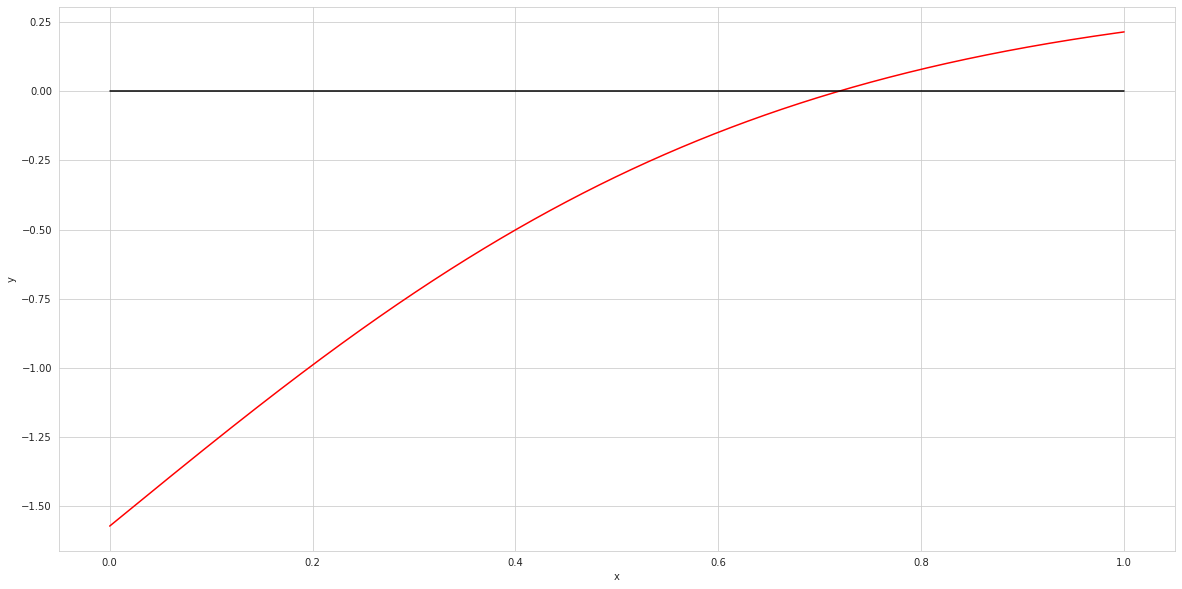

In [19]:
# Нарисуем график функции на отрезке [0, 1]
draw_func(function=func, segment=segment, interval=0.0001)

### 1. Метод бисекции

In [14]:
bisection_method = BisectionMethod(func, segment, epsilon)
bisection_method.find_solution()

Метод бисекции на отрезке [0, 1] с точностью до 0.01:

x = 0.711	iterations = 8

+----+----------+-------------+-----------+--------------+-------+
|    |  X_left  |  f(X_left)  |  X_right  |  f(X_right)  |   ∆   |
+====+==========+=============+===========+==============+=======+
| 1  |    0     |   -1.571    |     1     |    0.215     |   1   |
+----+----------+-------------+-----------+--------------+-------+
| 2  |   0.5    |   -0.307    |     1     |    0.215     |  0.5  |
+----+----------+-------------+-----------+--------------+-------+
| 3  |   0.5    |   -0.307    |   0.75    |    0.033     | 0.25  |
+----+----------+-------------+-----------+--------------+-------+
| 4  |  0.625   |   -0.113    |   0.75    |    0.033     | 0.125 |
+----+----------+-------------+-----------+--------------+-------+
| 5  |  0.688   |   -0.035    |   0.75    |    0.033     | 0.062 |
+----+----------+-------------+-----------+--------------+-------+
| 6  |  0.688   |   -0.035    |   0.719   |     

### 2. Метод секущих

In [15]:
secant_method = SecantMethod(func, segment, epsilon)
secant_method.find_solution()

Метод секущих на отрезке [0, 1] с точностью до 0.01:

x = 0.718	iterations = 6

+----+----------+-------------+-----------+--------------+-------+
|    |  X_left  |  f(X_left)  |  X_right  |  f(X_right)  |   ∆   |
+====+==========+=============+===========+==============+=======+
| 1  |    0     |   -1.571    |     1     |    0.215     |   1   |
+----+----------+-------------+-----------+--------------+-------+
| 2  |    1     |    0.215    |   0.88    |    0.143     | 0.12  |
+----+----------+-------------+-----------+--------------+-------+
| 3  |   0.88   |    0.143    |   0.642   |    -0.091    | 0.238 |
+----+----------+-------------+-----------+--------------+-------+
| 4  |  0.642   |   -0.091    |   0.735   |    0.017     | 0.093 |
+----+----------+-------------+-----------+--------------+-------+
| 5  |  0.735   |    0.017    |   0.72    |    0.002     | 0.015 |
+----+----------+-------------+-----------+--------------+-------+
| 6  |   0.72   |    0.002    |   0.718   |      

### 3. Метод ложной позиции

In [16]:
false_position_method = FalsePositionMethod(func, segment, epsilon)
false_position_method.find_solution()

Метод ложной позиции на отрезке [0, 1] с точностью до 0.01:

x = 0.725	iterations = 7

+----+----------+-------------+-----------+--------------+-------+
|    |  X_left  |  f(X_left)  |  X_right  |  f(X_right)  |   ∆   |
+====+==========+=============+===========+==============+=======+
| 1  |    0     |   -1.571    |     1     |    0.215     |   1   |
+----+----------+-------------+-----------+--------------+-------+
| 2  |    0     |   -1.571    |   0.88    |    0.143     | 0.12  |
+----+----------+-------------+-----------+--------------+-------+
| 3  |    0     |   -1.571    |   0.807   |    0.085     | 0.073 |
+----+----------+-------------+-----------+--------------+-------+
| 4  |    0     |   -1.571    |   0.765   |    0.047     | 0.042 |
+----+----------+-------------+-----------+--------------+-------+
| 5  |    0     |   -1.571    |   0.743   |    0.025     | 0.022 |
+----+----------+-------------+-----------+--------------+-------+
| 6  |    0     |   -1.571    |   0.731   

### 4. Метод Ньютона

In [17]:
newton_method = NewtonMethod(func, derivative_func, segment, epsilon)
newton_method.find_solution()

Метод Ньютона в первоначальной точке 0.5 с точностью до 0.01:

x = 0.719	iterations = 3

+----+-------+--------+-------+-------+
|    |   X   |   F    |  df   |   ∆   |
+====+=======+========+=======+=======+
| 0  |  0.5  | -0.307 | 1.76  |   0   |
+----+-------+--------+-------+-------+
| 1  | 0.675 | -0.307 | 1.76  | 0.175 |
+----+-------+--------+-------+-------+
| 2  | 0.716 | -0.05  | 1.202 | 0.042 |
+----+-------+--------+-------+-------+
| 3  | 0.719 | -0.002 | 1.086 | 0.002 |
+----+-------+--------+-------+-------+

#------------------------------------------------------------------------------#

Метод Ньютона в первоначальной точке 0.5 с точностью до 0.001:

x = 0.7185	iterations = 4

+----+--------+---------+--------+--------+
|    |   X    |    F    |   df   |   ∆    |
+====+========+=========+========+========+
| 0  |  0.5   | -0.3071 |  1.76  |   0    |
+----+--------+---------+--------+--------+
| 1  | 0.6745 | -0.3071 |  1.76  | 0.1745 |
+----+--------+---------+--------